In [14]:

import numpy as np
import cv2
import mediapipe as mp
import time
import glob
import tensorflow as tf

from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, Rescaling
from keras.layers import BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

# Parameters and Model

In [2]:

emotions = {
    0: ['Angry', (0,0,255), (255,255,255)],
    1: ['Disgust', (0,102,0), (255,255,255)],
    2: ['Fear', (255,255,153), (0,51,51)],
    3: ['Happy', (153,0,153), (255,255,255)],
    4: ['Sad', (255,0,0), (255,255,255)],
    5: ['Surprise', (0,255,0), (255,255,255)],
    6: ['Neutral', (160,160,160), (255,255,255)]
}
num_classes = len(emotions)
input_shape = (48, 48, 1)
weights_1 = 'saved_models/vggnet.h5'
weights_2 = 'saved_models/vggnet_up.h5'

In [3]:
class VGGNet(Sequential):
    def __init__(self, input_shape, num_classes, checkpoint_path, lr=1e-3):
        super().__init__()
        self.add(Rescaling(1./255, input_shape=input_shape))
        self.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal'))
        self.add(BatchNormalization())
        self.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(MaxPool2D())
        self.add(Dropout(0.5))

        self.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(MaxPool2D())
        self.add(Dropout(0.4))

        self.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(MaxPool2D())
        self.add(Dropout(0.5))

        self.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(MaxPool2D())
        self.add(Dropout(0.4))

        self.add(Flatten())
        
        self.add(Dense(1024, activation='relu'))
        self.add(Dropout(0.5))
        self.add(Dense(256, activation='relu'))

        self.add(Dense(num_classes, activation='softmax'))

        self.compile(optimizer=Adam(learning_rate=lr),
                    loss=categorical_crossentropy,
                    metrics=['accuracy'])
        
        self.checkpoint_path = checkpoint_path

In [16]:
model_1 = VGGNet(input_shape, num_classes, weights_1)
model_1.load_weights(model_1.checkpoint_path)

model_2 = VGGNet(input_shape, num_classes, weights_2)
model_2.load_weights(model_2.checkpoint_path)

In [29]:
model = load_model("model_RAFDB2.h5")

# Inference

In [18]:
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils
face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.5)

In [19]:
def detection_preprocessing(image, h_max=360):
    h, w, _ = image.shape
    if h > h_max:
        ratio = h_max / h
        w_ = int(w * ratio)
        image = cv2.resize(image, (w_,h_max))
    return image

def resize_face(face):
    x = tf.expand_dims(tf.convert_to_tensor(face), axis=2)
    return tf.image.resize(x, (48,48))

def recognition_preprocessing(faces):
    x = tf.convert_to_tensor([resize_face(f) for f in faces])
    return x

In [20]:
def inference(image):
    H, W, _ = image.shape
    
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_detection.process(rgb_image)

    if results.detections:
        faces = []
        pos = []
        for detection in results.detections:
            box = detection.location_data.relative_bounding_box
            # mp_drawing.draw_detection(image, detection)

            x = int(box.xmin * W)
            y = int(box.ymin * H)
            w = int(box.width * W)
            h = int(box.height * H)

            x1 = max(0, x)
            y1 = max(0, y)
            x2 = min(x + w, W)
            y2 = min(y + h, H)

            face = image[y1:y2,x1:x2]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            faces.append(face)
            pos.append((x1, y1, x2, y2))
    
        x = recognition_preprocessing(faces)

        y_1 = model_1.predict(x)
        y_2 = model_2.predict(x)
        l = np.argmax(y_1+y_2, axis=1)

        for i in range(len(faces)):
            cv2.rectangle(image, (pos[i][0],pos[i][1]),
                            (pos[i][2],pos[i][3]), emotions[l[i]][1], 2, lineType=cv2.LINE_AA)
            
            cv2.rectangle(image, (pos[i][0],pos[i][1]-20),
                            (pos[i][2]+20,pos[i][1]), emotions[l[i]][1], -1, lineType=cv2.LINE_AA)
            
            cv2.putText(image, f'{emotions[l[i]][0]}', (pos[i][0],pos[i][1]-5),
                            0, 0.6, emotions[l[i]][2], 2, lineType=cv2.LINE_AA)
    
    return image

# Image

In [21]:

def infer_single_image(path):
    image = cv2.imread(path)
    image = detection_preprocessing(image)
    result = inference(image)
    cv2.imwrite('run/inference/out.jpg', result)

def infer_multi_images(paths):
    for i, path in enumerate(paths):
        image = cv2.imread(path)
        image = detection_preprocessing(image)
        result = inference(image)
        cv2.imwrite('run/inference/out_'+str(i)+'.jpg', result)

1/1 [==============================] - 0s 21ms/step


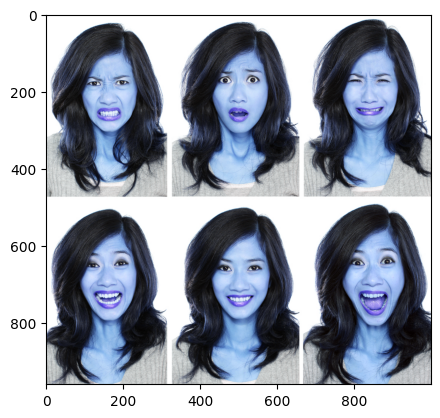

In [27]:
import matplotlib.pyplot as plt

infer_single_image("C:/Users/darks/Downloads/faces5.jpg")
out = cv2.imread('C:/Users/darks/Downloads/faces5.jpg')
# Display the output image
plt.imshow(out)
plt.show()

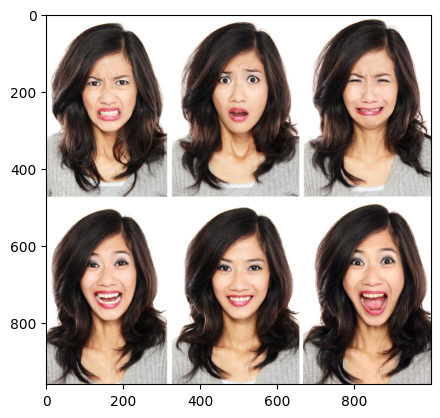

In [25]:
out = cv2.imread('C:/Users/darks/Downloads/faces5.jpg')
out = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
plt.imshow(out)
plt.show()

In [28]:
paths = np.sort(np.array(glob.glob('images/*.jpg')))
infer_multi_images(paths)
out_paths = np.sort(np.array(glob.glob('run/inference/*.jpg')))
for path in out_paths:
    image = cv2.imread(path)
    imshow(image)

In [33]:
import cv2
import numpy as np
import tensorflow as tf
import mediapipe as mp

mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils
face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.5)

emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

def detection_preprocessing(image, h_max=360):
    h, w, _ = image.shape
    if h > h_max:
        ratio = h_max / h
        w_ = int(w * ratio)
        image = cv2.resize(image, (w_,h_max))
    return image

def resize_face(face):
    return cv2.resize(face, (48, 48))

def recognition_preprocessing(faces):
    return tf.convert_to_tensor([resize_face(f) for f in faces])

def inference(image):
    H, W, _ = image.shape
    
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_detection.process(rgb_image)

    if results.detections:
        faces = []
        pos = []
        for detection in results.detections:
            box = detection.location_data.relative_bounding_box
            # mp_drawing.draw_detection(image, detection)

            x = int(box.xmin * W)
            y = int(box.ymin * H)
            w = int(box.width * W)
            h = int(box.height * H)

            x1 = max(0, x)
            y1 = max(0, y)
            x2 = min(x + w, W)
            y2 = min(y + h, H)

            face = image[y1:y2,x1:x2]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            faces.append(face)
            pos.append((x1, y1, x2, y2))
    
        x = recognition_preprocessing(faces)

        y_1 = model_1.predict(x)
        y_2 = model_2.predict(x)
        l = np.argmax(y_1+y_2, axis=1)

        # create array of rectangle coordinates
        rect_coords = np.array(pos)
        rect_coords[:,2] += 20 # increase width
        rect_coords[:,1] -= 20 # move up
        rect_coords[:,3] = [p[3] for p in pos] # set bottom y to original y

        # create array of emotion colors and texts
        colors = np.array([emotions[i][1] for i in range(len(l))])
        texts = np.array([emotions[i][0] for i in range(len(l))])
        fonts = np.array([emotions[i][2] for i in range(len(l))])


        # draw rectangles
        cv2.rectangle(image, tuple(rect_coords[:, :2].T), tuple(rect_coords[:, 2:].T), colors.tolist(), 2, lineType=cv2.LINE_AA)

        # draw filled rectangles
        cv2.rectangle(image, tuple(rect_coords[:, :2].T), tuple(rect_coords[:, [2,1]].T), colors.tolist(), -1, lineType=cv2.LINE_AA)

        # draw text
        for i, text in enumerate(texts):
            text_size, _ = cv2.getTextSize(text, fonts[i], 0.6, 2)
            cv2.putText(image, text, (pos[i][0], pos[i][1] - 5), fonts[i], 0.6, colors[i], 2, lineType=cv2.LINE_AA)
    
    return image


In [34]:
image = cv2.imread('C:/Users/darks/Downloads/faces5.jpg')
image = detection_preprocessing(image)
image = inference(image)
cv2.imshow('image', image)
cv2.waitKey(0)
cv2.destroyAllWindows()


1/1 [==============================] - 0s 21ms/step


error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - argument for rectangle() given by name ('lineType') and position (5)
>  - argument for rectangle() given by name ('lineType') and position (5)


# Video

In [ ]:
video = 'test_video/emotions.mp4'
cap = cv2.VideoCapture(video)
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = cap.get(cv2.CAP_PROP_FPS)
target_h = 360
target_w = int(target_h * frame_width / frame_height)
out = cv2.VideoWriter('run/out.avi',cv2.VideoWriter_fourcc('M','J','P','G'),
                      fps, (target_w,target_h))

In [ ]:

while True:
    success, image = cap.read()
    if success:
        image = resize_image(image)
        result = inference(image)
        out.write(result)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
    
cap.release()
out.release()
cv2.destroyAllWindows()

# Cam

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='cap/photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
filename = take_photo()
image = cv2.imread(filename)
result = inference(image)
cv2_imshow(result)